In [ ]:
!pip install statsmodels --upgrade
!pip install pandas --upgrade

In [1]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#from statsmodels.tsa.statespace.sarimax.SARIMAX import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import os
import enum
import numpy as np
import csv

ModuleNotFoundError: No module named 'pandas'

In [ ]:
!wget -O ukdale_group.zip https://github.com/Vita98/MMSAProject/raw/main/Dataset/ukdale_group.zip
!unzip ./ukdale_group.zip
!mkdir result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
class TrainignTimeType(enum.IntEnum):
	ONE_WEEK = 10080
	ONE_MONTH = 43200

class TestingTimeType(enum.IntEnum):
	ONE_DAY = 1440

In [4]:
'''
	PUT HERE THE CONFIGURATION VALUES
										'''
trainSize = TrainignTimeType.ONE_WEEK
testSize = TestingTimeType.ONE_DAY

originFileName = "ukdale_def4.csv"
seriesName = "Tv_Dvd_Lamp"


In [15]:
#Save the time series given as parameter 
def save_series_to_csv(series, fileName):
	path = "results/SARIMA/" + originFileName[:-4]

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	path = "results/SARIMA/" + originFileName[:-4] + "/" + seriesName

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	day = trainSize / 1440
	file = open(path + "/" + str(int(day)) + "days_" + fileName, "w")
	file.write(series.to_csv(header=False))
	file.close()

#
def save_accuracy_to_csv(values, fileName, seriesName):
	path = "results/SARIMA/" + originFileName[:-4]

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	path = "results/SARIMA/" + originFileName[:-4] + "/" + seriesName

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	day = trainSize / 1440
	#file = open(path + "/" + str(int(day)) + "days_" + fileName + "accuracy", "w")

	with open(path + "/" + fileName, mode="a") as csv_file:
		fieldnames = ['mape', 'corr', 'rmse', 'minmax', 'seriesName', 'days']
		writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

		writer.writerow({'mape':values.get("mape"),'corr':values.get("corr"),'rmse':values.get("rmse"),'minmax':values.get("minmax"), 'seriesName':seriesName, 'days':day})

		
		

	csv_file.close()

#Save the plot from pyplot
def save_plot():
	path = "results/SARIMA/" + originFileName[:-4]

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	path = "results/SARIMA/" + originFileName[:-4] + "/" + seriesName
	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	day = trainSize / 1440
	finalPath = path + "/" + str(int(day)) + "days_plot.png"
	pyplot.savefig(finalPath, dpi=100)

#Parser for the read_csv
def parser(x):
	return datetime.strptime(x, '%y-%m-%d %H:%M:%S')

In [6]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 
            'corr':corr, 'rmse':rmse,'minmax':minmax})


Time
2013-03-09 14:40:00    12.88
2013-03-09 14:41:00    12.90
2013-03-09 14:42:00    12.70
2013-03-09 14:43:00    12.50
2013-03-09 14:44:00    12.80
Name: Tv_Dvd_Lamp, dtype: float64

Training the model...



/home/ali/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/home/ali/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/home/ali/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing...
{'mape': 0.6162345163604126, 'corr': 0.4627883817217318, 'minmax': 0.19914947860477306}

All done!



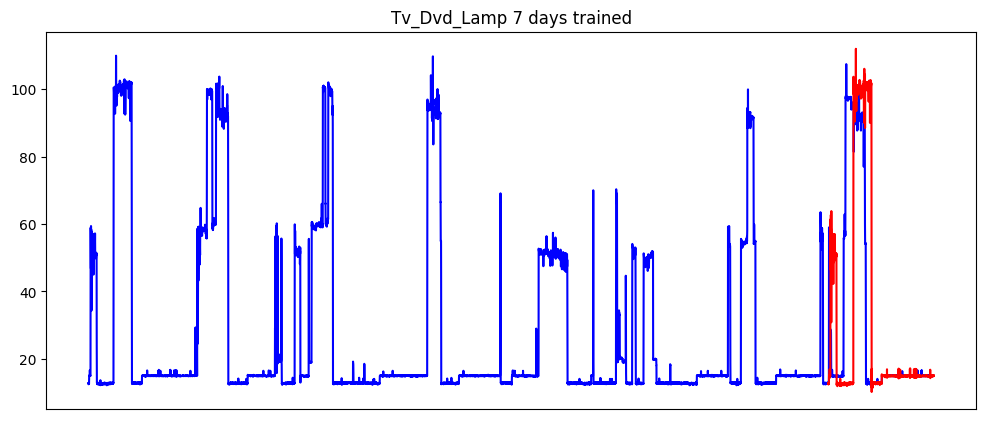

In [16]:
#main function
numbersOfRowToRead = int(trainSize) + int(testSize)

#Reading the series from the dataset file
series = read_csv("Dataset/" + originFileName,header=0,index_col=0,nrows=numbersOfRowToRead, usecols=["Time", seriesName])
print(series[seriesName].head())

#Splitting the dataset into training and testing 
X = series[seriesName]
train, test = X[0:trainSize], X[trainSize:trainSize+testSize]
history = [x for x in train]
predictions = list()

print("\nTraining the model...\n")

maxLen = len(test)
"""
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
"""
#creating SARIMA model
my_order = (1, 0, 1)
my_seasonal_order = (0, 0, 1, 12)
# define model

model = sm.tsa.statespace.SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False,
                                enforce_invertibility=False)

model_fit = model.fit()

# plot forecasts against actual outcomes
yhat = model_fit.predict(start=0, end=len(test))
#print(yhat)
predictions = list()

for value in yhat[1:]:
    predictions.append(value)

print("Testing...")


fc_series = pd.Series(predictions,index=test.index)

# evaluate forecasts
print(forecast_accuracy(fc_series.values, test.values))


pyplot.figure(figsize=(12,5), dpi=100)
pyplot.plot(train, color='blue')
pyplot.plot(test, color='blue')
pyplot.plot(fc_series, color='red')
day = trainSize / 1440
pyplot.title(seriesName + " " + str(int(day)) + " days trained")
ax = pyplot.gca()
ax.axes.xaxis.set_visible(False)

#saving date
save_series_to_csv(train, "train.csv")
save_series_to_csv(test, "test.csv")
save_series_to_csv(fc_series, "predictions.csv")
save_accuracy_to_csv(values, "accuracy.csv", seriesName)
save_plot()
#pyplot.show()

print("\nAll done!\n")

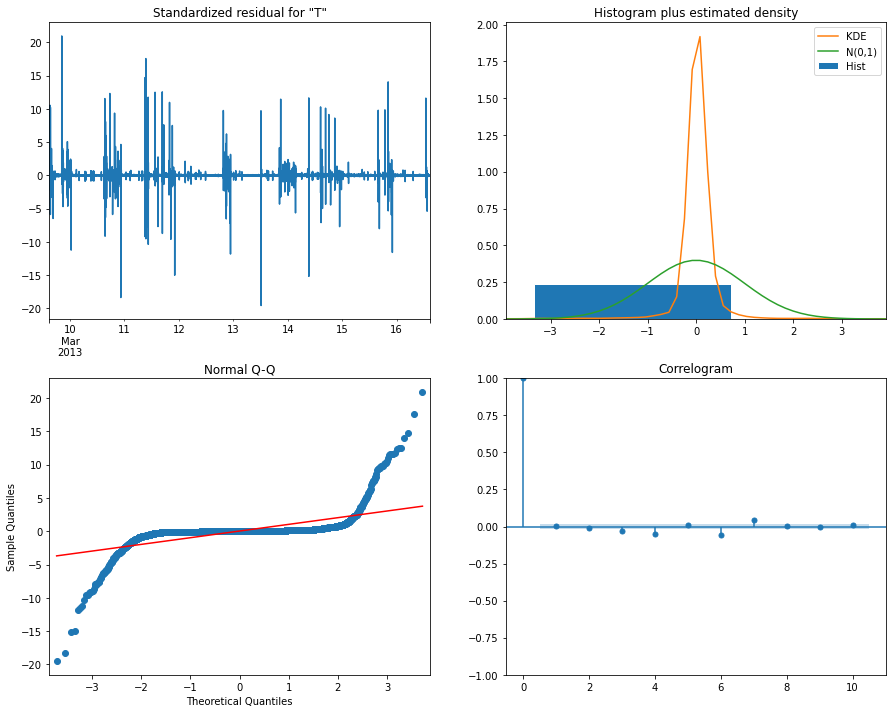

In [17]:
model_fit.plot_diagnostics(figsize=(15,12));